In [1]:
#Notebook for doing the actual classification


In [2]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, TextDataset, AudioNText
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten, LSTMnet_RnnAtten_late, LateFusion
import numpy as np
from sklearn.metrics import f1_score


In [3]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = '..\\text_only\\embeddings\\bert_embeddings'
val_bert = '..\\text_only\\embeddings\\bert_embeddings_val'
test_bert = '..\\text_only\\embeddings\\bert_embeddings_test'

train_audio = '..\\data\\MELD\\audio\\wav\\'
val_audio = '..\\data\\MELD\\audio\\wav_dev\\'
test_audio = '..\\data\\MELD\\audio\\wav_test\\'

In [4]:
em = False
audio_train = AudioDataset(train_annotations, train_audio, emotion=em)
audio_val = AudioDataset(val_annotations, val_audio, emotion=em)


text_train = TextDataset(train_annotations, train_bert, emotion=em)
text_val = TextDataset(val_annotations, val_bert, emotion=em)


In [5]:

train = AudioNText(audio_train, text_train)
val = AudioNText(audio_val, text_val)


batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=False)


train_features, train_labels = next(iter(train_dataloader))

In [6]:
val_dataloader = DataLoader(val, batch_size=len(val), shuffle=False, drop_last=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if em:
    weight=torch.tensor([1-1109/9989, 1-271/9989, 1-268/9989, 1-1743/9989, 1-4710/9989, 1-683/9989, 1-1205/9989]).to(device=device)
else:
    weight=torch.tensor([1-2945/9989, 1-2334/9989, 1-4710/9989]).to(device=device)



In [8]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss(weight=weight, label_smoothing=0.0)(input=predictions,target=targets)

In [9]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X, Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [10]:
def make_validate_fnc(model,loss_fnc):
    def validate(X ,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X)
            predictions = torch.argmax(output_logits,dim=1)
            
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_audio = LSTMnet_RnnAtten_late(input_dim = 104, hidden_dim=128, output_dim=3, num_layers=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model_audio.parameters()) )


Number of trainable params:  483331


In [12]:
model_text = LSTMnet_RnnAtten_late(input_dim = 768, hidden_dim=128, output_dim=3, num_layers=2).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model_text.parameters()) )

Number of trainable params:  691203


In [13]:
model_audio.load_state_dict(torch.load("..\\audio\\best-model-parameters-audio-sent.pt"))
model_text.load_state_dict(torch.load("..\\text_only\\best-model-params_sent_weighted.pt"))

<All keys matched successfully>

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LateFusion(6, 3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

Number of trainable params:  21


In [15]:

OPTIMIZER = torch.optim.Adam(model.parameters(),lr=01e-5, weight_decay=1e-3) #???
train_step = make_train_step(model, loss_fnc, OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 100 #
best_val_f1 = 2
j = False


for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        text = model_text(X_tensor[:,:768])
        audio = model_audio(X_tensor[:,768:])
        combined_tensor = torch.cat((audio, text), axis=1)
        loss, acc, f1= train_step(combined_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
   
    text_val = model_text(X_val_tensor[:,:768])
    audio_val = model_audio(X_val_tensor[:,768:])
    combined_tensor_val = torch.cat((audio_val, text_val), axis = 1)
 
    val_loss, val_acc, _, val_f1= validate(combined_tensor_val,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_loss < best_val_f1:
        torch.save(model.state_dict(), 'model_parameters/latefusion/best-model-parameters-latefusion_sent1.pt')
        best_epoch = epoch
        best_val_f1 = val_loss
        j = True
       
       
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}%")
    
if j:
    print('saved')


Epoch 1 --> loss:1.1585, acc:38.30%, val_loss:1.1272, val_acc:38.18%  f1:45.83%, val_f1:33.77%

Epoch 2 --> loss:1.1561, acc:38.49%, val_loss:1.1310, val_acc:39.80%  f1:76.67%, val_f1:35.11%

Epoch 3 --> loss:1.1536, acc:38.93%, val_loss:1.1315, val_acc:38.81%  f1:30.00%, val_f1:34.29%

Epoch 4 --> loss:1.1566, acc:38.85%, val_loss:1.1257, val_acc:38.27%  f1:25.00%, val_f1:33.80%

Epoch 5 --> loss:1.1534, acc:38.09%, val_loss:1.1240, val_acc:39.71%  f1:76.67%, val_f1:35.08%

Epoch 6 --> loss:1.1548, acc:37.85%, val_loss:1.1294, val_acc:39.17%  f1:20.00%, val_f1:34.63%

Epoch 7 --> loss:1.1526, acc:39.00%, val_loss:1.1234, val_acc:38.63%  f1:30.00%, val_f1:34.13%

Epoch 8 --> loss:1.1511, acc:39.06%, val_loss:1.1232, val_acc:39.62%  f1:66.67%, val_f1:34.98%

Epoch 9 --> loss:1.1514, acc:38.34%, val_loss:1.1252, val_acc:38.81%  f1:30.00%, val_f1:34.27%

Epoch 10 --> loss:1.1519, acc:38.09%, val_loss:1.1216, val_acc:39.71%  f1:0.00%, val_f1:35.09%

Epoch 11 --> loss:1.1500, acc:38.18%, v

1.0894768238067627


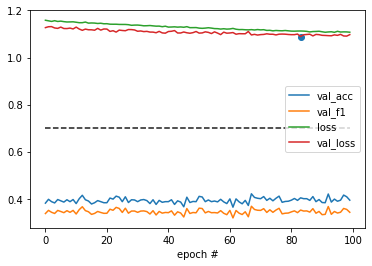

In [16]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()


print(best_val_f1)


In [17]:
torch.save(model.state_dict(), "model_parameters/latefusion/best-model-parameters-latefusion_sent.pt")

In [23]:
model.load_state_dict(torch.load("model_parameters/latefusion/best-model-parameters-latefusion_sent.pt"))

<All keys matched successfully>

In [18]:
audio_test = AudioDataset(test_annotations, test_audio, emotion=em)
text_test = TextDataset(test_annotations, test_bert, emotion=em)

In [19]:
test = AudioNText(audio_test, text_test)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False, drop_last=False)

In [24]:



device = 'cpu'
model_audio.to(device)
model_text.to(device)
model.to(device)
f1s = []
f1ss = []

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    text = model_text(X_tensor[:,:768])
    audio = model_audio(X_tensor[:,768:])
    combined_tensor = torch.cat((audio, text), axis=1)
    output_logits = model(combined_tensor)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    f1_ = f1_score(Y.cpu(), predictions.cpu(), average=None)
    f1s.append(f1)
    f1ss.append(f1_)

print(f1)
print(f1_)
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
#  emotions = {'negative':0, 'positive':1, 'neutral':2}

0.35698851278095894
[0.33529098 0.         0.5193057 ]
